In [1]:
import os
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision import models
import numpy as np

In [2]:
class EarDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


In [3]:
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.Rotate(limit=30, p=0.6),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.ElasticTransform(p=0.3),
    A.GridDistortion(p=0.2),
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3-2651380383.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3),


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
data_dir = "/content/drive/MyDrive/Dataset1/images"
known_classes = ['000', '001', '002', '003', '004', '005', '006', '007', '011', '012']
unknown_classes = ['008', '009', '010']
all_classes = known_classes + unknown_classes
label_dict = {name: idx for idx, name in enumerate(all_classes)}


In [78]:
image_paths = []
labels = []
for class_name in known_classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.png")):
            image_paths.append(img_path)
            labels.append(label_dict[class_name])

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = EarDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = EarDataset(val_paths, val_labels, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
unknown_paths = []
unknown_labels = []
for class_name in unknown_classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.png")):
            unknown_paths.append(img_path)
            unknown_labels.append(label_dict[class_name])

unknown_dataset = EarDataset(unknown_paths, unknown_labels, transform=val_transforms)
unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False)


In [80]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_acc = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        scheduler.step()
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return model, history


In [81]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch

# Get number of classes from train_labels
num_classes = len(set(train_labels))

# Load pretrained EfficientNet and modify final layer
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function (CrossEntropy is good for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1/20 - Train Acc: 0.7431, Val Acc: 0.9400
Epoch 2/20 - Train Acc: 0.9563, Val Acc: 0.9850
Epoch 3/20 - Train Acc: 0.9675, Val Acc: 0.9950
Epoch 4/20 - Train Acc: 0.9756, Val Acc: 0.9975
Epoch 5/20 - Train Acc: 0.9831, Val Acc: 0.9925
Epoch 6/20 - Train Acc: 0.9888, Val Acc: 0.9975
Epoch 7/20 - Train Acc: 0.9962, Val Acc: 0.9950
Epoch 8/20 - Train Acc: 0.9956, Val Acc: 1.0000
Epoch 9/20 - Train Acc: 0.9962, Val Acc: 1.0000
Epoch 10/20 - Train Acc: 0.9981, Val Acc: 1.0000
Epoch 11/20 - Train Acc: 0.9975, Val Acc: 1.0000
Epoch 12/20 - Train Acc: 0.9969, Val Acc: 1.0000
Epoch 13/20 - Train Acc: 0.9981, Val Acc: 1.0000
Epoch 14/20 - Train Acc: 0.9975, Val Acc: 1.0000
Epoch 15/20 - Train Acc: 0.9981, Val Acc: 0.9975
Epoch 16/20 - Train Acc: 0.9944, Val Acc: 1.0000
Epoch 17/20 - Train Acc: 0.9875, Val Acc: 0.9975
Epoch 18/20 - Train Acc: 0.9719, Val Acc: 0.9725
Epoch 19/20 - Train Acc: 0.9431, Val Acc: 0.9775
Epoch 20/20 - Train Acc: 0.9681, Val Acc: 0.9900


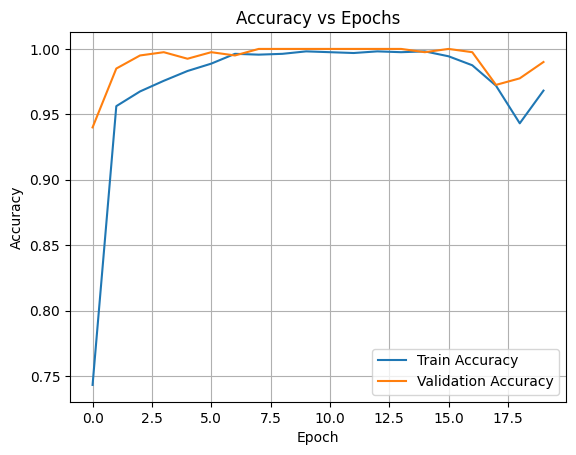

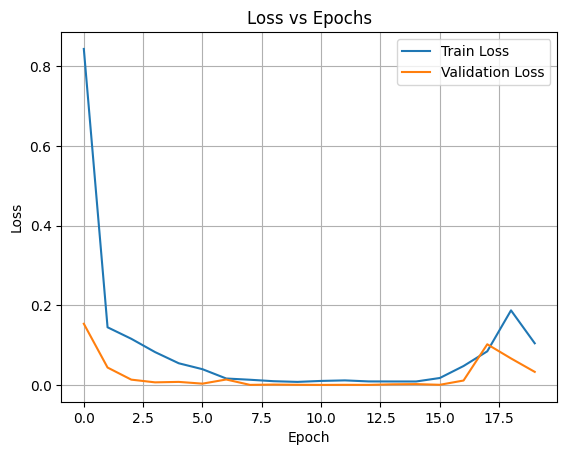

In [83]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, val_loader, class_names):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:
               precision    recall  f1-score   support

         000       1.00      1.00      1.00        40
         001       1.00      1.00      1.00        40
         002       0.95      1.00      0.98        40
         003       1.00      1.00      1.00        40
         004       1.00      0.97      0.99        40
         005       1.00      0.95      0.97        40
         006       0.98      1.00      0.99        40
         007       0.97      0.97      0.97        40
         011       1.00      1.00      1.00        40
         012       1.00      1.00      1.00        40

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



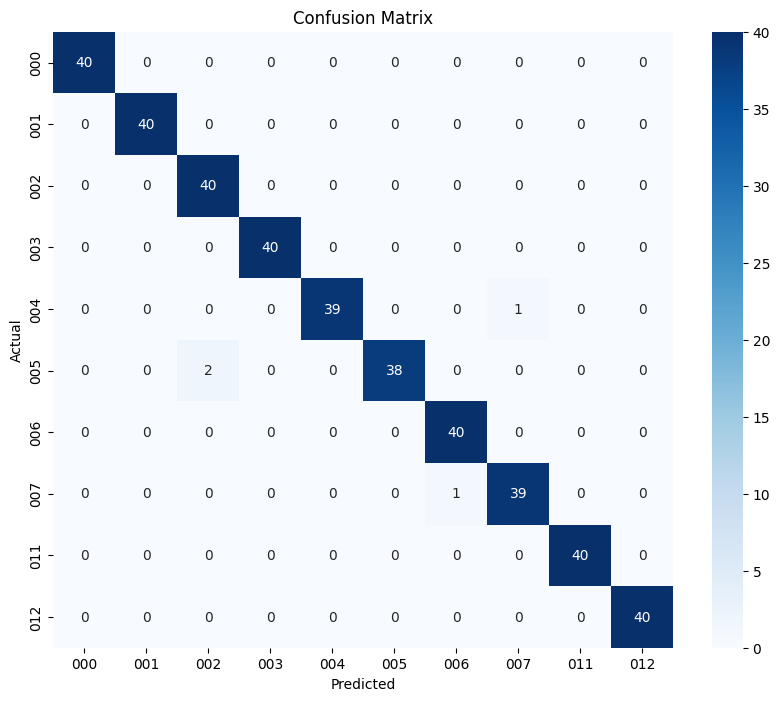

In [85]:
class_names = ['000', '001', '002', '003', '004', '005', '006', '007', '011', '012']  # or your class labels
evaluate_model(model, val_loader, class_names)

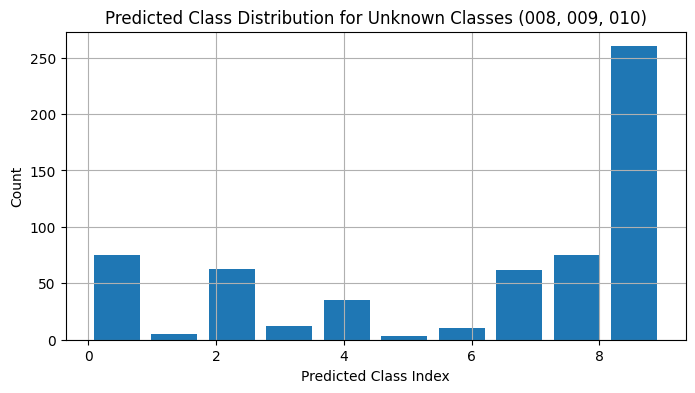

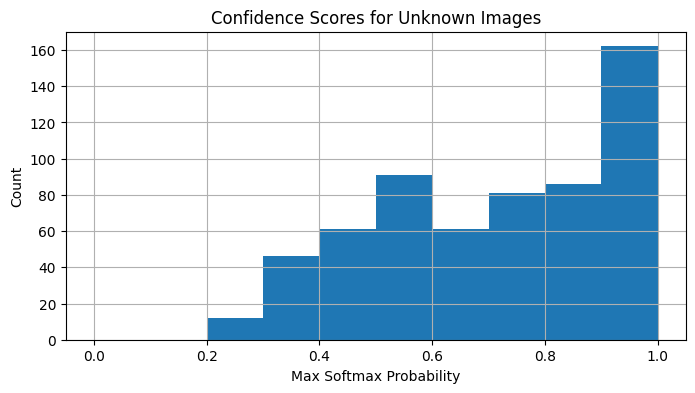

Unknown Detection Rate (confidence < 0.7): 45.17%


In [86]:
unknown_preds = []
unknown_confidences = []
unknown_true_labels = []

model.eval()
with torch.no_grad():
    for images, labels in unknown_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        unknown_preds.extend(preds.cpu().numpy())
        unknown_confidences.extend(max_probs.cpu().numpy())
        unknown_true_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(8, 4))
plt.hist(unknown_preds, bins=len(set(train_labels)), rwidth=0.8)
plt.title("Predicted Class Distribution for Unknown Classes (008, 009, 010)")
plt.xlabel("Predicted Class Index")
plt.ylabel("Count")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(unknown_confidences, bins=10, range=(0, 1))
plt.title("Confidence Scores for Unknown Images")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

unknown_flagged = [1 if conf < 0.7 else 0 for conf in unknown_confidences]
unknown_detected_rate = sum(unknown_flagged) / len(unknown_flagged)
print(f"Unknown Detection Rate (confidence < 0.7): {unknown_detected_rate:.2%}")